<a href="https://colab.research.google.com/github/hirurana/tennis_sim/blob/main/tennis_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Tennis Match Simulator

In [ ]:
#imports 
import copy
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from progressbar import ProgressBar

In [ ]:
#game state updater
def update_game_state(winner, g_st):
    # init vars
    loser = abs(winner-1)
    ad_out = False
    current = copy.deepcopy(g_st)[-1]
    # is deuce?
    if (current[winner] == current[loser] and current[winner] == 3) or (max(current) == 4 and min(current) == 3):
        # if other side is winning sub their score and do not increment
        if current[winner] < current[loser]:
            ad_out = True
    
    # increment point
    if not ad_out:
        current[winner] += 1 
    else:
        current[loser] -= 1 #leader loses advantage
    g_st.append(current)
    return g_st

In [ ]:
update_game_state(1, [[0,0], [0,1]])

[[0, 0], [0, 1], [0, 2]]

In [ ]:
# set state updater
def update_set_state(winner, s_st): 
    #use each point to update the current game state
    current_game_num = list(s_st.keys())[-1]
    g_st = s_st[current_game_num]

    # simulate the point won in current game
    g_st = update_game_state(winner, g_st)

    # get current score
    current_sc = g_st[-1]
    
    #if game has been won start new game
    loser = abs(winner-1)
    if (current_sc[winner] >= 4 and current_sc[loser] < 3) or current_sc[winner] == 5:        
        #start new game
        new_game_num = 'game'+str(len(s_st)+1)
        s_st[new_game_num] = [[0,0]]
    return s_st, g_st

In [ ]:
# match state updater
def update_match_state(winner, m_st):
    '''
        TODO:
        #deal with tie-breaks and advantage sets in final set
        #allow configuration to other formats
    '''
    
    # get first set
    current_set_num = list(m_st.keys())[-1]
    s_st = m_st[current_set_num]
    
    loser = abs(winner-1)
    
    #simulate a single point in a game in a set
    s_st, cg_score = update_set_state(winner, s_st)
    #calculate set score
    game_scores = [g[-1].index(max(g[-1])) for g in list(s_st.values()) if max(g[-1]) >= 4] #only check compeleted matches
    w_wins = game_scores.count(winner)
    l_wins = game_scores.count(loser)

    set_scores = [0,0]
    set_scores[winner] = w_wins
    set_scores[loser] = l_wins

    #determine if the set has been won and start new set
    if (w_wins-l_wins) >=2 and w_wins >= 6:
            #TODO: fix the appearing game
            del s_st[list(s_st.keys())[-1]]
            #start new set
            new_set_num = 'set'+str(len(m_st)+1)
            m_st[new_set_num] = {'game1': [[0,0]]}
            s_st = m_st[new_set_num]
    return m_st, set_scores, cg_score

Check if the current leader is about to play for a critical point

In [ ]:
# #Critical Point checker
# def critical_point_check(current_scores, p0_prob, nf):
#     '''
#         Reduces probability of player winning if is a critical point
#     '''
#     #parse current_states
#     cg_score, cs_scores, m_score = current_scores
#     nerv_prob = p0_prob
    
#     #check if game point
#     game_points = [set([0,3]),set([1,3]),set([2,3]), set([5,3])]
    
#     #TODO: if player is serving for game reduce p
    
    
#     #  if critical point reduce prob of winning
#     if set(cg_score) in game_points:
#         # reduce p
#         nerv_prob*=(1-nf)
#         #check if set point
#         if min(cs_scores) >= 4 and max(cs_scores)-min(cs_scores) == 1:
#             #reduce p again
#             nerv_prob*=(1-nf)
#             #check if match point
#             if max(m_score)-min(m_score) == 1:
#                 # reduce p again
#                 nerv_prob*=(1-nf)

#     return None if p0_prob == nerv_prob else [nerv_prob,1-nerv_prob]

Function to play a single match

In [ ]:
import numpy as np
# Simulate match from list of inputs
def play_match(p0_prob):
    '''
        TODO: 
        Allow configurability of how match can be won
    '''
    # init vars and state
    p1_prob = 1-p0_prob
    point_probs = [p0_prob,p1_prob]
    winner = -1
    match_st = {'set1': {'game1': [[0, 0]]}}
    cg_score = cs_scores = m_score = [0,0]
    
    # run until match won
    while True:
        # generate stream of inputs
        point = np.random.choice([0,1], p=point_probs)
        
        # update match state, returns current match, set and game state
        match_st, cs_scores, cg_score = update_match_state(point, match_st)
        
        # check if game won
        if len(match_st) > 2:
            # calc set scores
            game_scores = [[g.index(max(g)) for g in list(s.values())] for s in list(match_st.values())[:-1]]
            set_scores = [1 if s.count(1) > s.count(0) else 0 for s in game_scores]
            w_wins = set_scores.count(point)
            l_wins = set_scores.count(abs(point-1))
            
            m_score[point] = w_wins
            m_score[abs(point-1)] = l_wins
            
            # check if match won, break loop (best of three)
            if (w_wins-l_wins) >=2 or len(match_st) == 3:
                #remove new extra set
                del match_st[list(match_st.keys())[-1]]
                winner = point
                break
            # players have tied, play one more set
    
    return match_st, winner

Simulate a number of matches

In [ ]:
def simulate_matches(p0_prob, num_matches):
    #init vars for hists
    results = num_sets_played = num_games_played = all_game_outcomes = np.array([])

    for i in range(0,num_matches):
        #get the result of playing a single game
        match_result, winner = play_match(p0_prob)
        results = np.concatenate((results,winner), axis=None)

        #get all game outcomes from the match
        game_outcomes = np.array([[g[-1].index(max(g[-1])) for g in list(s.values())] for s in list(match_result.values())[:-1]]).flatten()
        all_game_outcomes = np.concatenate((all_game_outcomes, game_outcomes), axis=None)
        
        #get number of sets played in the match
        num_sets_played = np.append(num_sets_played,len(match_result))
        
        #get number of games played in the match
        num_games_played = np.concatenate((num_games_played,[len(s) for s in list(match_result.values())]), axis=None)
    
    return results, num_sets_played, num_games_played, all_game_outcomes

# 2 - Histograms

In [ ]:
#run simulation
results, num_sets_played, num_games_played, all_game_outcomes = simulate_matches(0.45, 1000)

In [ ]:
# print(results)
# print(np.count_nonzero(results))
# _, match_counts = np.unique(results, return_counts=True)
# print(match_counts)
# print('-----')
# print(all_game_outcomes[:100])

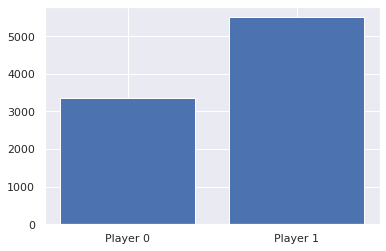

Player 0 won 37.94813979706877% games
Player 1 won 62.05186020293123% games


In [ ]:
#Game Outcomes
p1_game_counts = np.count_nonzero(all_game_outcomes)
p0_game_counts = len(all_game_outcomes)-p1_game_counts

game_counts = [p0_game_counts, p1_game_counts]
p1_game_win_probs = p1_game_counts/len(all_game_outcomes)
p0_game_win_probs = 1 - p1_game_win_probs
plt.bar(['Player 0', 'Player 1'], game_counts)
plt.show()
print(f"Player 0 won {p0_game_win_probs*100}% games\nPlayer 1 won {p1_game_win_probs*100}% games")

818 818


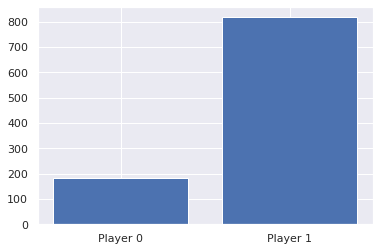

Player 0 won 18.200000000000006% games
Player 1 won 81.8% games


In [ ]:
#Match Outcomes
p1_match_counts = np.count_nonzero(results)
p0_match_counts = len(results)-p1_match_counts

_, counts = np.unique(results, return_counts=True)
print(p1_match_counts, counts[1])

match_counts= [p0_match_counts, p1_match_counts]
p1_match_win_probs = p1_match_counts/len(results)
p0_match_win_probs = 1 - p1_match_win_probs
plt.bar(['Player 0', 'Player 1'], match_counts)
plt.show()
print(f"Player 0 won {p0_match_win_probs*100}% games\nPlayer 1 won {p1_match_win_probs*100}% games")

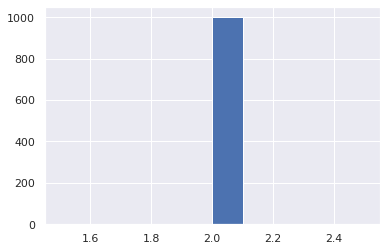

In [ ]:
#histogram of number of sets played
plt.hist(num_sets_played)
plt.show()

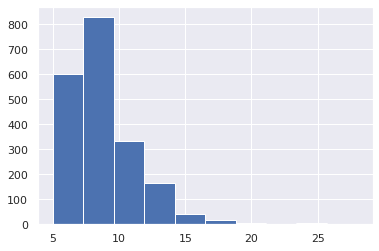

In [ ]:
#histogram of number of games played per set
plt.hist(num_games_played)
plt.show()

# 3 - Varying Probability of Player 0

In [ ]:
def get_match_win_prob(p, num_matches=100):
  results, num_sets_played, num_games_played, all_game_outcomes = simulate_matches(p, num_matches)
  p0_win_prob = 1 - (np.count_nonzero(results)/num_matches)
  return p0_win_prob

In [ ]:
match_probs = []
num_matches=1000

print('Running', num_matches, 'simulations varying p0 probability by 1%...')
pbar = ProgressBar()
for i in pbar(range(100)):
  p0 = i/100
  p0_win_prob = get_match_win_prob(p0, num_matches)
  match_probs.append(p0_win_prob)

N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Running 1000 simulations varying p0 probability by 1%...


100% (100 of 100) |######################| Elapsed Time: 0:06:48 Time:  0:06:48


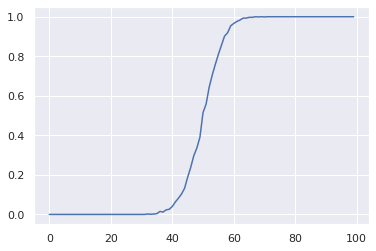

In [ ]:
plt.plot(match_probs)

# 4 - Markov Chain

## Help Functions

In [167]:
import numpy as np
def create_state_trans_mat(win_point, p0_prob, return_states=False):
  # init vars
  adv_win_point = win_point+1
  deuce_or_tie_point = adv_win_point - 2
  p1_prob = 1 - p0_prob

  # generate list of states (and add deuce/tiebreak wins)
  states = [(i,j) for i in range(adv_win_point) for j in range(adv_win_point)] + [(deuce_or_tie_point,adv_win_point),(adv_win_point,deuce_or_tie_point)]
  states.remove((win_point,win_point)) # remove unachievable state

  states = dict(zip([i for i in range(len(states))], states))

  # init state transition matrix
  P = np.zeros((len(states), len(states)))
  counter = 0
  # fill with normal game probs
  for i in range(len(states)):
    for j in range(len(states)):
      # score cannot return to prev score after point played
      if not states[i] == states[j]:
        prev = states[i]
        next = states[j]
        # score can't change by more than one point
        if (abs(next[0]-prev[0])<=1 and next[1] == prev[1]) or (abs(next[1]-prev[1])<=1 and next[0] == prev[0]):
          # next score cannot be lower than prev score
          if next[0]>= prev[0] and next[1]>= prev[1]:
            # if game already won loser cannot win anymore points
            if not ((next[0]==prev[0]==win_point) or (next[1]==prev[1]==win_point)):
              if next[0]>prev[0]:
                P[i,j] = p0_prob
              elif next[1]>prev[1]:
                P[i,j] = p1_prob
      # however if absorbing state, return back to itself
      elif (win_point in set(states[i]) or adv_win_point in set(states[i])) and not set((win_point,deuce_or_tie_point)) == set(states[i]):
        P[i,j] = 1

  # add advantage (4,3)/(3,4) to deuce (3,3) transitions
  # get indexes of these states
  adv_idxs = [k for k,v in states.items() if set(v) == set((deuce_or_tie_point,win_point))]
  deuce_idx = [k for k,v in states.items() if set(v) == set((deuce_or_tie_point,deuce_or_tie_point))][0]

  # player 0 wins point
  P[adv_idxs[0], deuce_idx] = p0_prob
  # player 1 wins point
  P[adv_idxs[1], deuce_idx] = p1_prob

  if return_states:
    return P, states
  else:
    return P

In [168]:
def calc_stationary_dist(P, iterations = 400):
  P_row_size = P.shape[0]-1
  pi=np.array([1]+[0]*P_row_size)
  for i in range(iterations):
    pi = np.dot(pi, P)
  return pi

In [196]:
def get_probs(prob_dist, states):
  '''
  Get p0_prob and p1_prob from stationary distribution
  '''
  p0_prob = 0
  for i, prob in enumerate(prob_dist):
    score = states[i]
    p0_points = score[0]
    p1_points = score[1]
    if p0_points > p1_points:
      p0_prob += prob
  p1_prob = 1 - p0_prob
  print(f'P0 prob: {p0_prob}\nP1 prob: {p1_prob}')
  return p0_prob, p1_prob

In [183]:
def plot_trans_mat(P, states, size, level):
  """
  size -> Size of plot
  level -> Game/Set/Match for title formatting
  """
  plt.figure(figsize=size)
  plt.title(f'State Transition Matrix of a Tennis {level}')
  plt.tick_params(axis='both', labelbottom = False, bottom=False, top = False, labeltop=True)
  ax = sns.heatmap(P.T, annot=True, xticklabels=states.values(), yticklabels=states.values(),fmt=".1f", cbar=False)

In [171]:
def plot_stationary_dist(prob_dist, states, size, level):
  plt.figure(figsize=size)
  plt.title(f'Stationary Distribution of a Tennis {level}')
  plt.tick_params(axis='both', labelbottom = False, bottom=False, top = False)
  ax = sns.heatmap(np.expand_dims(prob_dist, axis=1), annot= True, yticklabels=states.values(),fmt=".6f")

## Game Analysis

In [172]:
# Generate state transition matrix for a tennis game
game_P, game_states = create_state_trans_mat(4, 0.47, return_states=True)

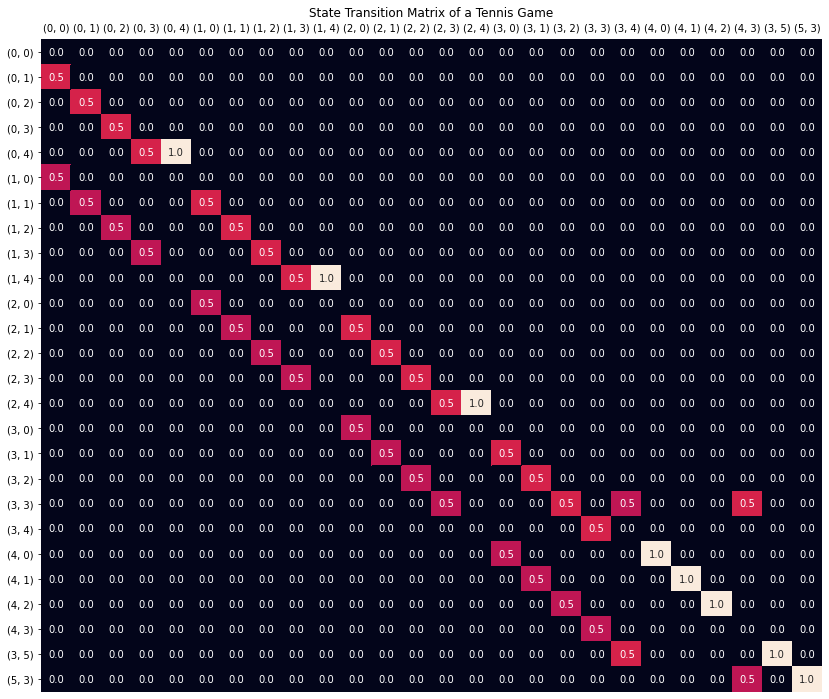

In [186]:
plot_trans_mat(game_P,game_states, size=(14, 12), level='Game')

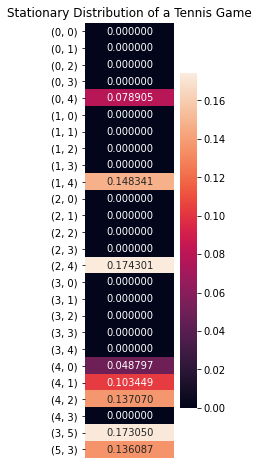

In [187]:
# Calculate Stationary Dist
game_prob_dist = calc_stationary_dist(game_P)
plot_stationary_dist(game_prob_dist, game_states, size=(2,8), level='Game')

In [192]:
p0_game_prob, p1_game_prob = get_probs(prob_dist, game_states)

P0 prob: 0.42540316017329605
P1 prob: 0.574596839826704


## Set Analysis

In [193]:
# Generate state transition matrix for a tennis set
set_P, set_states = create_state_trans_mat(6, p0_game_prob, return_states=True)

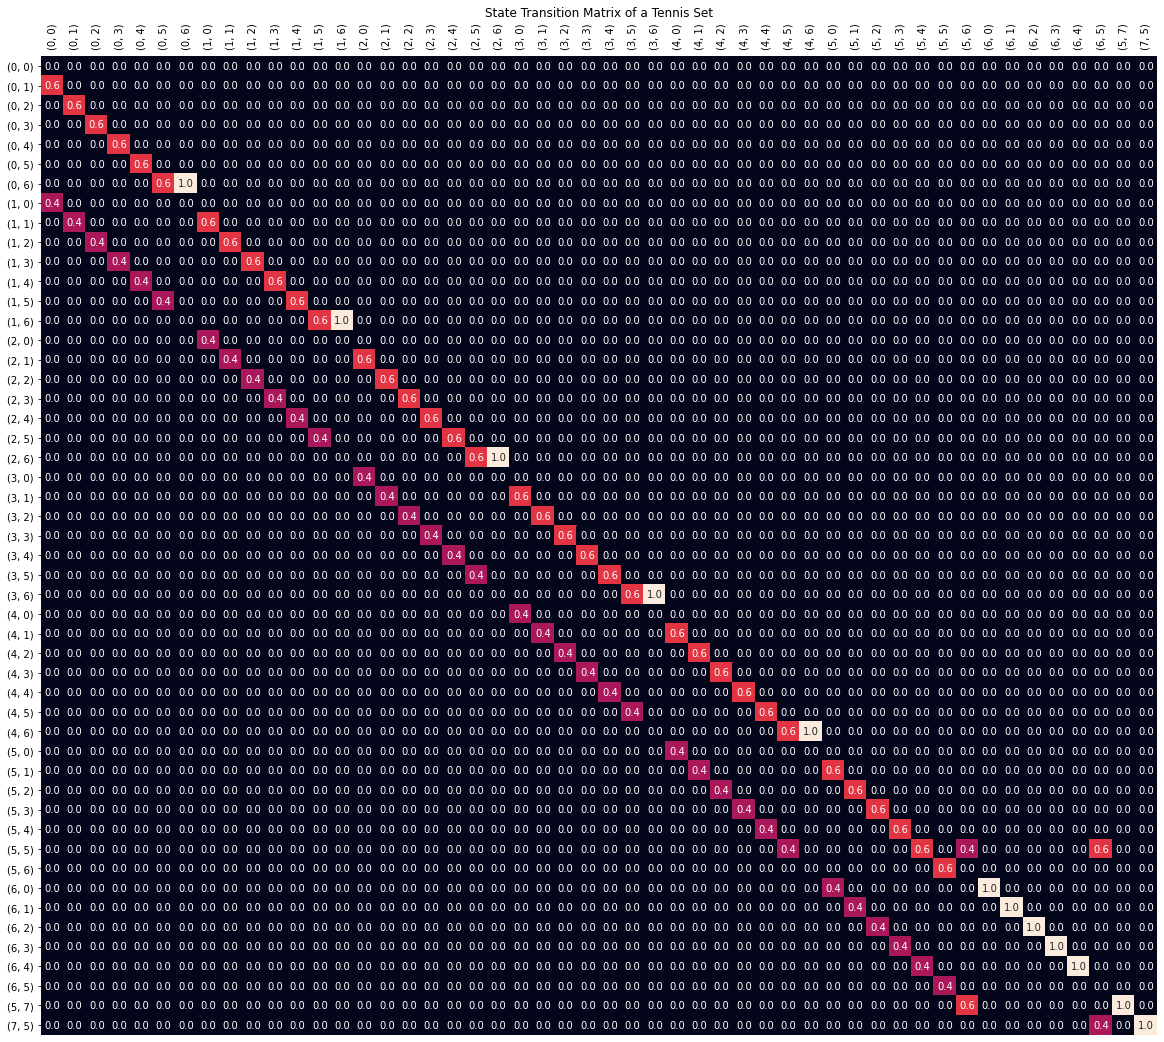

In [190]:
plot_trans_mat(set_P, set_states, size=(20,18), level='Set')

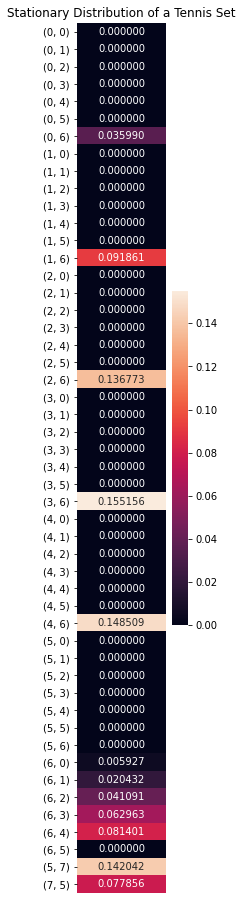

In [194]:
# Calculate Stationary Dist
set_prob_dist = calc_stationary_dist(set_P)
plot_stationary_dist(set_prob_dist, set_states, size=(2,16), level='Set')

In [198]:
# Get probability of P0 and P1 winning a single set from stationary distribution
p0_set_prob, p1_set_prob = get_probs(set_prob_dist, set_states)

P0 prob: 0.2896691754181253
P1 prob: 0.7103308245818747


## Match Analysis

In [201]:
# Generate state transition matrix for tennis match

# generate list of states
match_states = [(i,j) for i in range(3) for j in range(3)]
match_states.remove((2,2))

match_states = dict(zip([i for i in range(len(match_states))], match_states))
# init state transition matrix
match_P = np.zeros((len(match_states), len(match_states)))
counter = 0

# fill with normal match probs
for i in range(len(match_states)):
  for j in range(len(match_states)):
    # score cannot return to prev score after point played
    if not match_states[i] == match_states[j]:
      prev = match_states[i]
      next = match_states[j]
      # score can't change by more than one point
      if (abs(next[0]-prev[0])<=1 and next[1] == prev[1]) or (abs(next[1]-prev[1])<=1 and next[0] == prev[0]):
        # next score cannot be lower than prev score
        if next[0]>= prev[0] and next[1]>= prev[1]:
          # if set already won loser cannot win anymore points
          if not ((next[0]==prev[0]==2) or (next[1]==prev[1]==2)):
            if next[0]>prev[0]:
              match_P[i,j] = p0_set_prob
            elif next[1]>prev[1]:
              match_P[i,j] = p1_set_prob
    # however if absorbing state, return back to itself
    elif 2 in set(match_states[i]):
      match_P[i,j] = 1

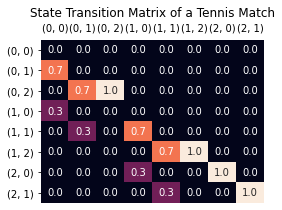

In [203]:
plot_trans_mat(match_P, match_states, size=(4,3), level='Match')

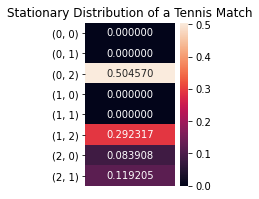

In [205]:
# Find Stationary Dist
match_prob_dist = calc_stationary_dist(match_P)
plot_stationary_dist(match_prob_dist, match_states, size=(2,3), level='Match')

In [207]:
# Get probability of P0 and P1 winning a match from stationary distribution
p0_match_prob, p1_match_prob = get_probs(match_prob_dist, match_states)

P0 prob: 0.20311343728454512
P1 prob: 0.7968865627154549
